In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

# Create our session (link) from Python to the DB
session = Session(engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
stat_query = session.query(Station)

Measurement = Base.classes.measurement
meas_query = session.query(Measurement)

In [8]:
df1 = pd.read_csv('Resources//hawaii_measurements.csv')
df1.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73


In [9]:
df2 = df1[['tobs']]
df2.head()

,tobs
0,65
1,63
2,74
3,76
4,73


In [10]:
df3 = pd.read_csv('Resources//hawaii_stations.csv')
df3.head()

,station,name,latitude,longitude,elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


## Bonus Challenge Assignment: Temperature Analysis II

In [11]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [12]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
print(calc_temps('2013-01-1', '2013-12-31'))
Tmin, Tavg, Tmax = calc_temps('2013-01-1', '2013-12-31')[0]

[(53.0, 72.73054810272134, 86.0)]


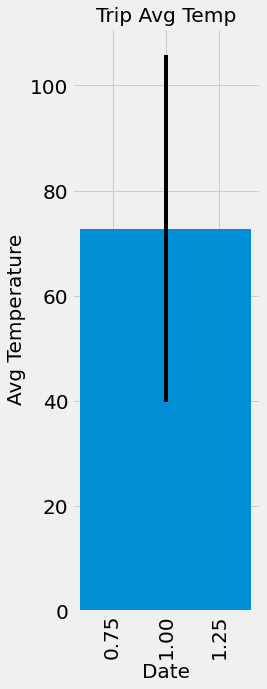

In [13]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = Tmax-Tmin
plt.figure(figsize= (3,10))
plt.bar(1 , Tavg, yerr= yerr)
plt.xlabel('Date', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 20)
plt.ylabel('Avg Temperature', fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Trip Avg Temp')
plt.show()

### Daily Rainfall Average

In [14]:
# Narrow down dates for df1 using .loc
df4 = df1.loc[(df1['date'] >= '2012-02-28') & (df1['date'] <= '2012-03-05')]
df4.head()

,station,date,prcp,tobs
729,USC00519397,2012-02-28,0.00,73
730,USC00519397,2012-02-29,0.00,74
731,USC00519397,2012-03-01,0.06,73
732,USC00519397,2012-03-02,0.00,67
733,USC00519397,2012-03-03,0.03,71


In [15]:
# Calculate the total amount of rainfall per weather station for your trip dates 
# using the previous year's matching dates.
series = df4.groupby('station')['prcp'].sum()
df5 = pd.DataFrame(series)
df5.head()

,prcp
station,
USC00511918,0.76
USC00513117,5.79
USC00514830,0.03
USC00516128,10.32
USC00517948,0.00


In [16]:
# Sort this in descending order by precipitation amount and list the 
# station, name, latitude, longitude, and elevation
# Merge dfs
df6 = df5.merge(df3 , on = 'station').sort_values(by = ['prcp'], ascending=False)
df6.head()

,station,prcp,name,latitude,longitude,elevation
6,USC00519281,11.08,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
3,USC00516128,10.32,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00513117,5.79,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
5,USC00518838,3.84,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
8,USC00519523,2.92,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5


### Daily Temperature Normals

In [17]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
print(daily_normals("01-01"))
Tmin, Tavg, Tmax = daily_normals("01-01")[0]

[(62.0, 69.15384615384616, 77.0)]


In [18]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start_date, end_date, freq='D')

# trip_dates1 = session.query.filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
# trip_dates2 = end_date - start_date
# Strip off the year and save a list of strings in the format %m-%d
trip_md = trip_dates.strftime('%m-%d')

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
for date in trip_md:
    normals.append(daily_normals(date))
normals = [a[0] for a in normals]
print(normals)

[(67.0, 75.54, 83.0), (68.0, 75.60377358490567, 84.0), (70.0, 76.61111111111111, 85.0), (69.0, 76.71153846153847, 84.0), (69.0, 76.14814814814815, 82.0), (67.0, 76.25, 83.0), (71.0, 77.15686274509804, 83.0)]


In [19]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df7 = pd.DataFrame(normals, columns = ['Tmin', 'Tavg', 'Tmax'])
df7['date'] = trip_dates
df7.head()

,Tmin,Tavg,Tmax,date
0,67.0,75.540000,83.0,2017-08-01
1,68.0,75.603774,84.0,2017-08-02
2,70.0,76.611111,85.0,2017-08-03
3,69.0,76.711538,84.0,2017-08-04
4,69.0,76.148148,82.0,2017-08-05


In [20]:
df8 = df7.set_index(['date'])
df8.head()

,Tmin,Tavg,Tmax
date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0


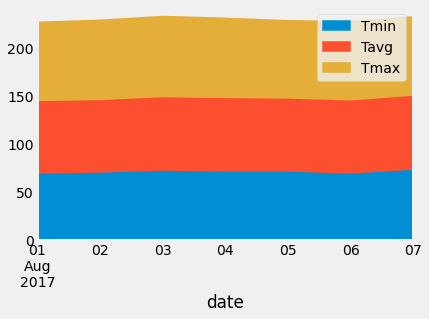

In [21]:
# Plot the daily normals as an area plot with `stacked=False`
ax = df8.plot.area()

## Close Session

In [22]:
session.close()